<a href="https://colab.research.google.com/github/sophiezydfifi/207fall-project-ding-peteh-valadez-zhang/blob/main/207_Milestone_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data processing**


In [5]:
import pandas as pd
from google.colab import files

In [6]:
# upload the file and please replace the file link
df = pd.read_csv("/content/NBA Player Stats and Salaries_2010-2025.csv")
print(df.shape)
df.head()

(7298, 31)


,Player,Salary,Year,Pos,Age,Team,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,23034375,2010,SG,31,LAL,73,73,38.8,9.8,...,0.811,1.1,4.3,5.4,5.0,1.5,0.3,3.2,2.6,27.0
1,Jermaine O'Neal,23016000,2010,C,31,MIA,70,70,28.4,5.6,...,0.720,1.8,5.2,6.9,1.3,0.4,1.4,1.8,3.0,13.6
2,Tracy McGrady,22843124,2010,SG,30,NYK,30,24,22.4,3.0,...,0.746,0.7,2.4,3.1,3.3,0.5,0.5,1.5,1.3,8.2
3,Tim Duncan,22183220,2010,C,33,SAS,78,77,31.3,7.2,...,0.725,2.8,7.3,10.1,3.2,0.6,1.5,1.8,1.9,17.9
4,Shaquille O'Neal,21000000,2010,C,37,CLE,53,53,23.4,4.9,...,0.496,1.8,4.9,6.7,1.5,0.3,1.2,2.0,3.2,12.0


In [7]:
# Quick structure overview
df.info()

# Check missing values
df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7298 entries, 0 to 7297
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7298 non-null   object 
 1   Salary  7298 non-null   int64  
 2   Year    7298 non-null   int64  
 3   Pos     7298 non-null   object 
 4   Age     7298 non-null   int64  
 5   Team    7298 non-null   object 
 6   G       7298 non-null   int64  
 7   GS      7298 non-null   int64  
 8   MP      7298 non-null   float64
 9   FG      7298 non-null   float64
 10  FGA     7298 non-null   float64
 11  FG%     7278 non-null   float64
 12  3P      7298 non-null   float64
 13  3PA     7298 non-null   float64
 14  3P%     6713 non-null   float64
 15  2P      7298 non-null   float64
 16  2PA     7298 non-null   float64
 17  2P%     7253 non-null   float64
 18  eFG%    7278 non-null   float64
 19  FT      7298 non-null   float64
 20  FTA     7298 non-null   float64
 21  FT%     7096 non-null   float64
 22  

,0
3P%,585
FT%,202
2P%,45
FG%,20
eFG%,20
Pos,0
Player,0
G,0
Team,0
GS,0


In [8]:
# For the missing values. They are all data derived from other non-missing columns. Hence I can fill percentage columns with 0
perc_cols = ["3P%", "FT%", "2P%", "FG%", "eFG%"]
df[perc_cols] = df[perc_cols].fillna(0)

# Double check
df[perc_cols].isnull().sum()

,0
3P%,0
FT%,0
2P%,0
FG%,0
eFG%,0


In [9]:
# I want to adjust all the salary from different years to the level of 2025 based on the NBA cap. (https://www.spotrac.com/nba/cba/)
#Salary Cap Maximum values (from  the NBA salary Cap table, 2010–2025)
cap_data = {
    "Year": [
        2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025
    ],
    "Cap": [
        58040000, 58044000, 58044000, 58679000,
        63065000, 70000000, 94143000, 99093000,
        101869000, 109140000, 109140000, 112414000,
        123655000, 136021000, 140588000, 154647000
    ]
}

cap_df = pd.DataFrame(cap_data)
cap_df

,Year,Cap
0,2010,58040000
1,2011,58044000
2,2012,58044000
3,2013,58679000
4,2014,63065000
5,2015,70000000
6,2016,94143000
7,2017,99093000
8,2018,101869000
9,2019,109140000


In [10]:
# Merge salary cap info into NBA dataset
df = df.merge(cap_df, on="Year", how="left")
# Define 2025 cap
cap_2025 = 154647000

# Adjust all salaries to 2025 cap level
df["Salary_2025_Adjusted"] = df["Salary"] * (cap_2025 / df["Cap"])

In [11]:
# encode categorical values like position and team
df = pd.get_dummies(df, columns=["Pos", "Team"], drop_first=True)

In [12]:
# define features for the training
X = df.drop(["Salary", "Salary_2025_Adjusted","Player","Year"], axis=1)  # drop columns I don't want to use
y = df["Salary_2025_Adjusted"]

In [13]:
#Many ML models (regression, KNN, neural nets) need features on similar scales.
#Tree models (Random Forest, Gradient Boosting) don’t need scaling, but it’s fine to keep a standardized version for consistency.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **EDA and visualizations**

In [14]:
#Classify the salary into low, mid and high categories
# Define quantile cutoffs (33rd and 66th percentiles)
q33 = df["Salary_2025_Adjusted"].quantile(0.33)
q66 = df["Salary_2025_Adjusted"].quantile(0.66)

# Create a categorical variable for salary tiers
def categorize_salary(salary):
    if salary <= q33:
        return "Low"
    elif salary <= q66:
        return "Medium"
    else:
        return "High"

df["Salary_Tier"] = df["Salary_2025_Adjusted"].apply(categorize_salary)

# Quick check of class balance
print(df["Salary_Tier"].value_counts())

Salary_Tier
High      2481
Low       2409
Medium    2408
Name: count, dtype: int64


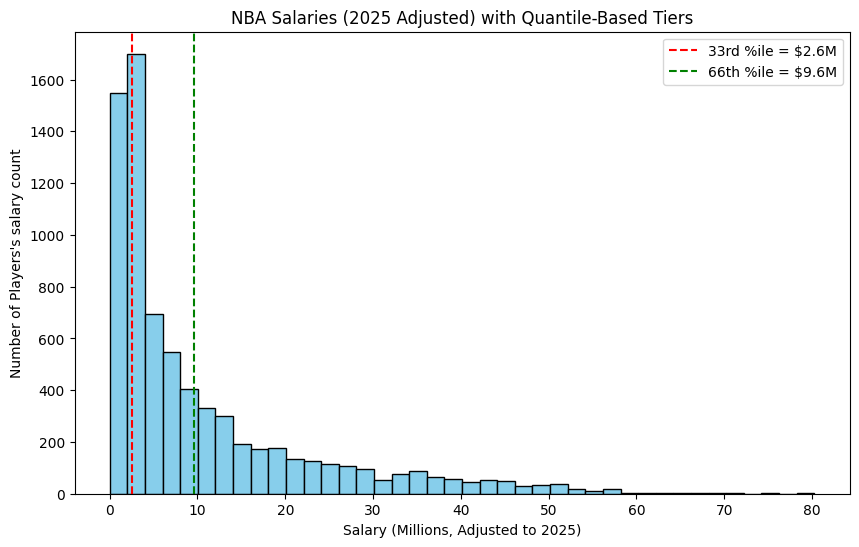

In [19]:
#plot the graph to show distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
plt.hist(df["Salary_2025_Adjusted"]/1e6, bins=40, color="skyblue", edgecolor="black")
plt.axvline(q33/1e6, color="red", linestyle="--", label=f"33rd %ile = ${q33/1e6:.1f}M")
plt.axvline(q66/1e6, color="green", linestyle="--", label=f"66th %ile = ${q66/1e6:.1f}M")
plt.title("NBA Salaries (2025 Adjusted) with Quantile-Based Tiers")
plt.xlabel("Salary (Millions, Adjusted to 2025)")
plt.ylabel("Number of Players's salary count")
plt.legend()
plt.show()